## Run the Self-Organizing Map
Training sample: KiDS <br>
Labeling sample: GAMA <br>
Validation sample: DESI <br>
___

First, load the data

In [2]:
from astropy.io import fits
from astropy.table import Table

import numpy as np

In [29]:
#Load in data
data_file = '/data2/lsajkov/mpdg/data_products/GAMA/GAMA_SOM_training_catalog_08Jul24.fits'

with fits.open(data_file) as cat:
    input_catalog_complete = Table(cat[1].data)

In [30]:
#Select the needed data
redshift_cut = input_catalog_complete['redshift'] <= 0.4

input_data = input_catalog_complete[redshift_cut]['r_mag', 'gr_col', 'ug_col', 'ri_col']#, 'ur_col']
input_stds = input_catalog_complete[redshift_cut]['r_mag_err', 'gr_col_err', 'ug_col_err', 'ri_col_err']#, 'ur_col_err']

input_labels     = input_catalog_complete[redshift_cut]['r_mag','gr_col', 'ug_col', 'ri_col', 'log_mstar', 'redshift']
input_label_stds = input_catalog_complete[redshift_cut]['r_mag_err', 'gr_col_err', 'ug_col_err', 'ri_col_err']

tuple_labels = input_labels.as_array()
list_labels  = [list(values) for values in tuple_labels]
input_labels = np.array(list_labels)

print(f'Len of input data: {len(input_data)}')

Len of input data: 47587


___

Initialize the SOM

In [4]:
from mpdg_som import SelfOrganizingMap

In [11]:
#Set parameters
name = 'mass_profile_dwarf_galaxies' #name of the SOM

mapsize   = [40, 40] #size of the map. pass as a list of dimensions OR as an integer (also pass number of dimensions)
dimension = None

initialization         = 'pca' #random or pca (principal component analysis)
termination            = 'either' #when to stop learning. maximum_steps = stop when maximum_steps have elapsed. error_thresh = stop when the error is below this threshold. either = stop when either condition is fulfilled
learning_rate_function = 'power_law' #which learning rate function to use. currently implemented: power_law
neighborhood_function  = 'gaussian' #which neighborhood function to use. currently implemented: gaussian
error_estimator        = 'quantization_error' #which error estimation function to use. currently implemented: max_misalignment

learning_rate = 0.5 #used to adjust the learning rate function
kernel_spread = 12.5 #used to adjust the neighborhood function
maximum_steps = 20 #used to adjust the learning rate and neighborhood functions
error_thresh  = 0.01 #used to stop the SOM if termination = 'error thresh'

In [12]:
#Declare the SOM
SOM = SelfOrganizingMap(
    name                   = name,
    mapsize                = mapsize,
    dimension              = dimension,
    initialization         = initialization,
    termination            = termination,
    learning_rate_function = learning_rate_function,
    neighborhood_function  = neighborhood_function,
    error_estimator        = error_estimator,
    learning_rate          = learning_rate,
    kernel_spread          = kernel_spread,
    maximum_steps          = maximum_steps,
    error_thresh           = error_thresh
)

In [13]:
data_cut = 30000 #use up to this much of the data (-1 for entire dataset)
randomized_idx = np.arange(0, len(input_data))
np.random.shuffle(randomized_idx)
randomized_data_idx  = randomized_idx[:data_cut]
randomized_label_idx = randomized_idx[data_cut:]

SOM.load_data(input_data[randomized_data_idx],
              variable_names = ['r_mag', 'g-r', 'u-g', 'r-i'])#, 'u-r'])
SOM.normalize_data()

SOM.load_standard_deviations(input_stds[randomized_data_idx])
SOM.normalize_standard_deviations()

SOM.data_statistics()

| Data statistics 
total entries: 30000

stat	r_mag	g-r	u-g	r-i	
min	0.000	0.000	0.000	0.000	
max	1.000	1.000	1.000	1.000	
mean	0.440	0.845	0.447	0.489	
median	0.457	0.855	0.453	0.490	
std	0.218	0.056	0.072	0.031	

In [14]:
#Initialize the SOM
SOM.build_SOM()


| SOM. Step 0. Initialization: pca
| Initial quantization error: 1.043


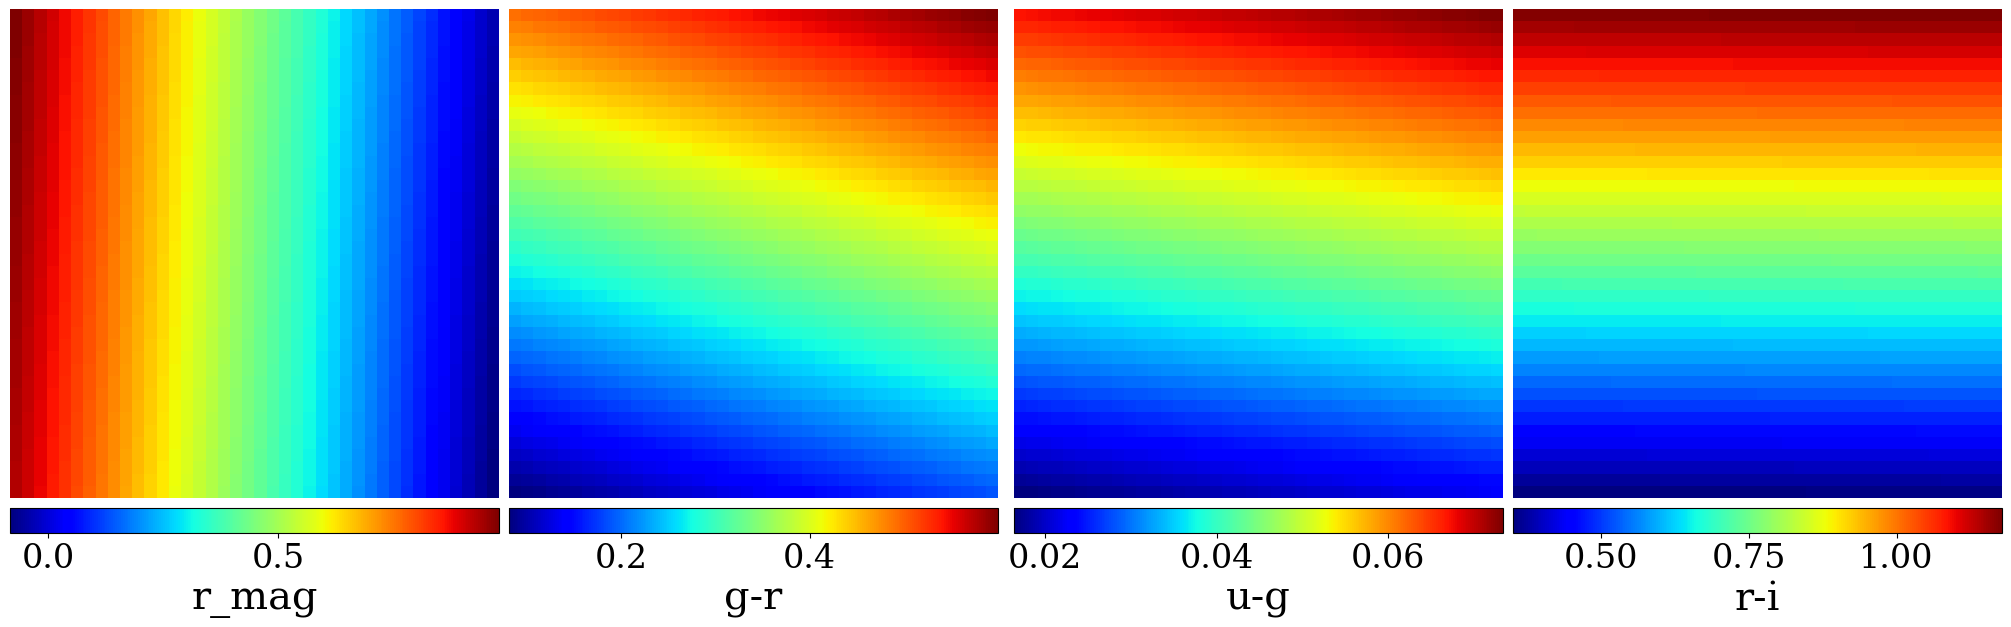

In [15]:
#Visualize SOM before training
SOM.show_map(cmap = 'jet')

#Look at initial quantization error
from mpdg_som_utils import SOM_ErrorEstimators

initial_quant_error = SOM_ErrorEstimators.quantization_error(SOM.weights_map,
                                                             SOM.data,
                                                             SOM.bmu_indices)
print(f'| Initial rms error: {initial_quant_error:.3f}')

In [16]:
#Train the som
SOM.train()

Step 1 complete. Error: 0.156                                   
Step 2 complete. Error: 0.130                                   
Step 3 complete. Error: 0.120                                   
Step 4 complete. Error: 0.132                                   
Step 5 complete. Error: 0.119                                   
Step 6 complete. Error: 0.107                                   
Step 7 complete. Error: 0.099                                   
Step 8 complete. Error: 0.101                                   
Step 9 complete. Error: 0.096                                   
Step 10 complete. Error: 0.095                                   
Step 11 complete. Error: 0.092                                   
Step 12 complete. Error: 0.092                                   
Step 13 complete. Error: 0.088                                   
Step 14 complete. Error: 0.087                                   
Step 15 complete. Error: 0.089                                   
Step 16 complete. E

0.073655814

In [ ]:
#Load trained map instead
SOM.weights_map = np.load('/data2/lsajkov/mpdg/saved_soms/weights.npy',
                          allow_pickle = True)
SOM.step = 10


| SOM. Step 20. Initialization: pca


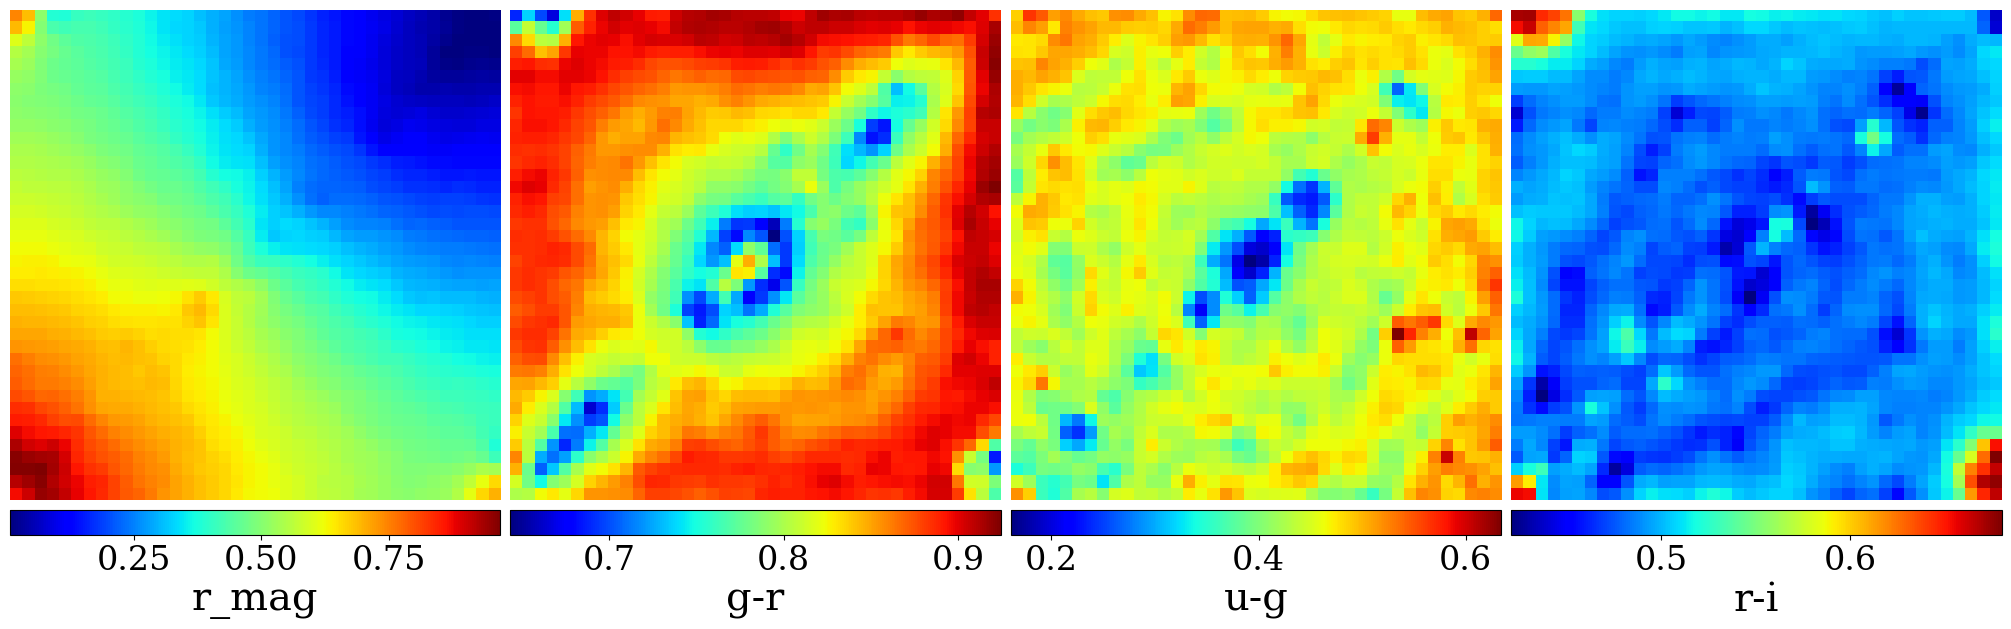

In [19]:
#Visualize the SOM after training
SOM.show_map(cmap = 'jet')

/data2/lsajkov/mpdg/strw_mpdg/mpdg_som.py:403: RuntimeWarning: invalid value encountered in divide
  labeled_map[iteration_map.multi_index][i] /= A_c
/data2/lsajkov/mpdg/strw_mpdg/mpdg_som.py:389: RuntimeWarning: divide by zero encountered in scalar divide
  sigma = np.sqrt((sigma_data ** 2) * (1 - 1/A_c) + (sigma_add ** 2)/N_cell)
/data2/lsajkov/mpdg/strw_mpdg/mpdg_som.py:389: RuntimeWarning: invalid value encountered in scalar divide
  sigma = np.sqrt((sigma_data ** 2) * (1 - 1/A_c) + (sigma_add ** 2)/N_cell)
/data2/lsajkov/mpdg/strw_mpdg/mpdg_som.py:391: RuntimeWarning: divide by zero encountered in scalar divide
  return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-((dist - np.mean(dist))**2)/ (2 * sigma ** 2))
/data2/lsajkov/mpdg/strw_mpdg/mpdg_som.py:391: RuntimeWarning: divide by zero encountered in divide
  return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-((dist - np.mean(dist))**2)/ (2 * sigma ** 2))
/data2/lsajkov/mpdg/strw_mpdg/mpdg_som.py:391: RuntimeWarning: invalid value encou


| SOM. Step 20. Initialization: pca


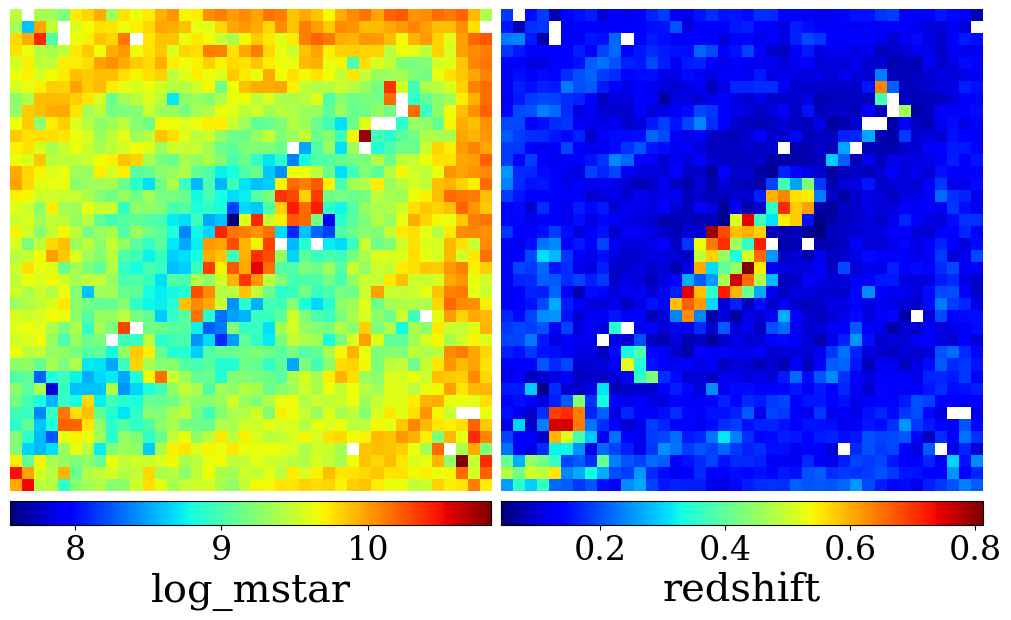

In [20]:
#Label the cells in the map with external parameters. Visualize the labeled map.
# SOM.load_labeling_data(input_labels[-int(data_cut):],

# for i, var in enumerate(SOM.normalization_params):
#     input_labels[:, i] -= SOM.normalization_params[var]['min']
#     input_labels[:, i] /= (SOM.normalization_params[var]['max'] - SOM.normalization_params[var]['min'])

#     print(input_label_stds.keys()[i], var)

#     input_label_stds[input_label_stds.keys()[i]] /= (SOM.normalization_params[var]['max'] - SOM.normalization_params[var]['min'])

SOM.load_labeling_data(input_labels[randomized_label_idx],
                       parameter_names = ['log_mstar', 'redshift'])
SOM.normalize_labeling_data()

SOM.load_labeling_standard_deviations(input_stds[randomized_label_idx])
SOM.normalize_labeling_standard_deviations()

SOM.label_map(pdr = 1000)

SOM.show_map(show_labeled = True,
             cmap = 'jet')

In [ ]:
from mpdg_som_utils import find_bmu_coords
import matplotlib.pyplot as plt

In [21]:
# SOM.predict(SOM.data)
SOM.predict(SOM.labeling_data[:, :4],
            SOM.label_variances[:, :4])

/data2/lsajkov/mpdg/strw_mpdg/mpdg_som.py:503: RuntimeWarning: invalid value encountered in sqrt
  prediction_sigmas[index] = np.sqrt(np.sum(self.distribution_xs ** 2 * self.labeled_map[*bmu_coords], axis = -1) -\


In [ ]:
SOM.save_outputs('/data2/lsajkov/mpdg/saved_soms',
                 save_weights = True, save_parameters = True)

In [ ]:
np.save('/data2/lsajkov/mpdg/saved_soms/10Jul24/prediction_results',
        SOM.prediction_results, allow_pickle = True)

In [ ]:
np.save('/data2/lsajkov/mpdg/saved_soms/10Jul24/labeling_data',
        SOM.labeling_data, allow_pickle = True)

___

Compare predictions to inputs

In [22]:
import matplotlib.pyplot as plt

<>:23: SyntaxWarning: invalid escape sequence '\o'
<>:24: SyntaxWarning: invalid escape sequence '\o'
<>:28: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\o'
<>:24: SyntaxWarning: invalid escape sequence '\o'
<>:28: SyntaxWarning: invalid escape sequence '\m'
/var/tmp/lsajkov/ipykernel_4164685/3476955548.py:23: SyntaxWarning: invalid escape sequence '\o'
  ax.set_xlabel('GAMA log$_{10} (M_*/M_{\odot})$\nTrue')
/var/tmp/lsajkov/ipykernel_4164685/3476955548.py:24: SyntaxWarning: invalid escape sequence '\o'
  ax.set_ylabel('Predicted\nSOM log$_{10} (M_*/M_{\odot})$')
/var/tmp/lsajkov/ipykernel_4164685/3476955548.py:28: SyntaxWarning: invalid escape sequence '\m'
  label = '$N_{\mathrm{galaxies}}$')


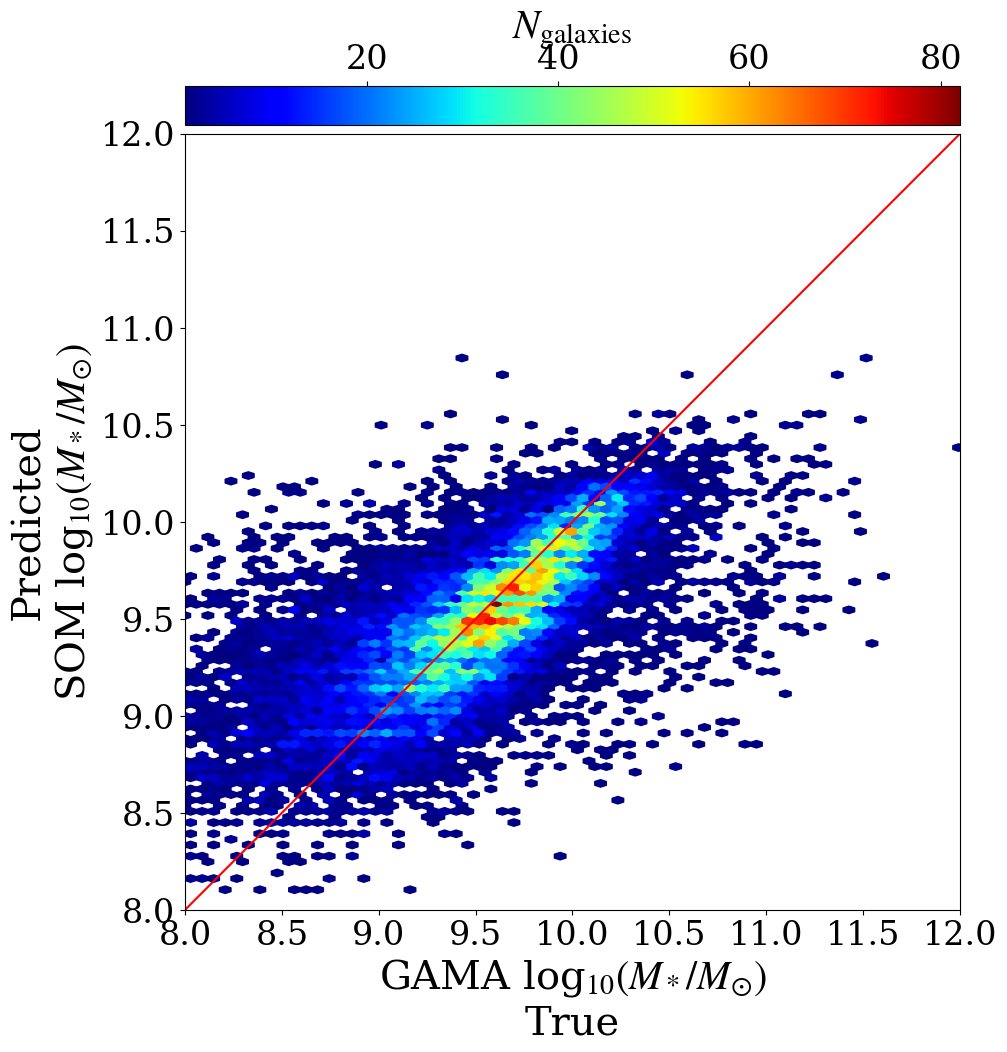

In [23]:
fig = plt.figure(figsize = (10, 12))

ax = fig.add_subplot()

hb = ax.hexbin(SOM.labeling_data[:, SOM.data_dim],
               SOM.prediction_results[:, 0],
               mincnt = 1, cmap = 'jet')

# ax.scatter(SOM.labeling_data[:, SOM.data_dim][lo_stripe_idx],
#            SOM.prediction_results[:, 0][lo_stripe_idx],
#            color = 'green', s = 50, facecolor = 'none')

# ax.scatter(SOM.labeling_data[:, SOM.data_dim][hi_stripe_idx],
#            SOM.prediction_results[:, 0][hi_stripe_idx],
#            color = 'red', s = 50, facecolor = 'none')

ax.axline([10, 10], slope = 1, color = 'red')

ax.set_xlim(8, 12)
ax.set_ylim(8, 12)
ax.set_xticks(np.arange(8, 12.5, 0.5))

ax.set_xlabel('GAMA log$_{10} (M_*/M_{\odot})$\nTrue')
ax.set_ylabel('Predicted\nSOM log$_{10} (M_*/M_{\odot})$')

fig.colorbar(ax = ax, mappable = hb,
             location = 'top', pad = 0.01,
             label = '$N_{\mathrm{galaxies}}$')

In [ ]:
np.sum((SOM.prediction_results[:, 1] > 0.33) & (SOM.labeling_data[:, -1] > 0.33) )/len(SOM.prediction_results) * 100

<>:30: SyntaxWarning: invalid escape sequence '\m'
<>:30: SyntaxWarning: invalid escape sequence '\m'
/var/tmp/lsajkov/ipykernel_4164685/4196949471.py:30: SyntaxWarning: invalid escape sequence '\m'
  label = '$N_{\mathrm{galaxies}}$')


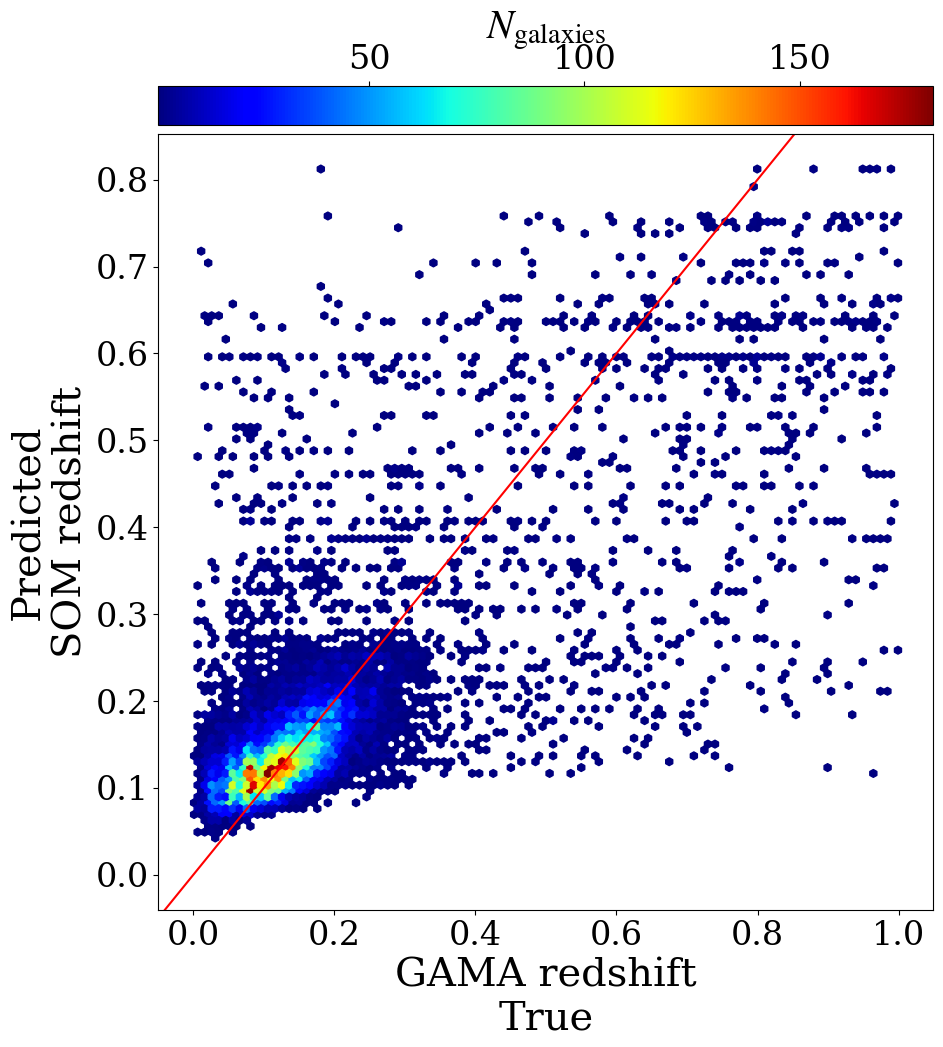

In [31]:
fig = plt.figure(figsize = (10, 12))

ax = fig.add_subplot()

hb = ax.hexbin(SOM.labeling_data[:, SOM.data_dim + 1],
               SOM.prediction_results[:, 1],
               mincnt = 1, cmap = 'jet')

# ax.scatter(SOM.labeling_data[:, SOM.data_dim + 1][lo_stripe_idx],
#            SOM.prediction_results[:, 1][lo_stripe_idx],
#            color = 'green', s = 50, facecolor = 'none')

# ax.scatter(SOM.labeling_data[:, SOM.data_dim + 1][hi_stripe_idx],
#            SOM.prediction_results[:, 1][hi_stripe_idx],
#            color = 'red', s = 50, facecolor = 'none')

ax.axline([0, 0], slope = 1, color = 'red')

# ax.set_xlim(0, 0.35)
# ax.set_ylim(0, 0.35)

ax.set_xlabel('GAMA redshift\nTrue')
ax.set_ylabel('Predicted\nSOM redshift')

# ax.axhline(0.33, color = 'black')
# ax.axvline(0.33, color = 'black')

fig.colorbar(ax = ax, mappable = hb,
             location = 'top', pad = 0.01,
             label = '$N_{\mathrm{galaxies}}$')

In [ ]:
SOM_zs = SOM.prediction_results[:, 1]

lo_stripe_idx = (SOM_zs < 0.4) & (SOM_zs > 0.35)
hi_stripe_idx = (SOM_zs < 0.6) & (SOM_zs > 0.5)

hi_stripe_r_mag = input_catalog_complete[-int(data_cut/2):][hi_stripe_idx]['r_mag']
lo_stripe_r_mag = input_catalog_complete[-int(data_cut/2):][lo_stripe_idx]['r_mag']

In [ ]:
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot()

ax.hist(lo_stripe_r_mag, bins = 'auto',
        histtype = 'step', color = 'green', linewidth = 5)

ax.set_xlabel('$r$-magnitude')

In [ ]:
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot()

ax.hist(hi_stripe_r_mag, bins = 'auto',
        histtype = 'step', color = 'red', linewidth = 5)

ax.set_xlabel('$r$-magnitude')